In [1]:
import numpy as np
import matplotlib.pyplot as plt

class DenseLayer():
  def __init__(self, units=1, activation='relu', weights=np.array([]), b=np.array([])):
    self.units = units # Кол-во нейронов
    self.fl_init = True # Флаг, показывающий созданы ли начальные веса и смещения
    self.activation = activation # Функция активации
    self.weights = weights # Скорректированные веса
    self.b_new = b # Скорректированные смещения
    self.w = np.array([]) # Начальные веса
    self.b = np.array([]) # Начальные веса

  def __call__(self, x):
    if (self.fl_init == True) and (self.weights.shape[0] == 0):
      self.w = np.random.normal(loc=0.0, scale=1.0, size=(x.shape[-1], self.units))/np.sqrt(2.0/x.shape[-1]) + 0.001
      self.b = np.ones(shape=(self.units, ), dtype=np.float32)
      self.fl_init = False
      # print(self.w.shape, self.weights)

    elif self.weights.shape[0] != 0:
      self.weights = self.weights.reshape((x.shape[-1], self.units))
      self.w = self.weights

      self.b_new = self.b_new.reshape((self.units))
      self.b = self.b_new
      self.fl_init = False

    y = x.dot(self.w) + self.b

    if self.activation == 'relu':
      return np.maximum(np.zeros(shape=y.shape), y), self.w, self.b, 1, self.units, self.activation
    if self.activation == 'Leaky_relu':
      return np.maximum(0.01*y, y), self.w, self.b, 1, self.units, self.activation
    if self.activation == 'softmax':
      return np.exp(y)/np.sum(np.exp(y), axis=0), self.w, self.b, 1, self.units, self.activation
    if self.activation == 'sigmoid':
      return 1 / (1 + np.exp(-y)), self.w, self.b, 1, self.units, self.activation
    if self.activation == 'tanh':
      return (np.exp(2*y) - 1)/(np.exp(2*y) + 1), self.w, self.b, 1, self.units, self.activation
    if self.activation == 'linear':
      return y, self.w, self.b, 1, self.units, self.activation

class Input():
  def __init__(self, shape=None):
    self.shape = shape

  def __call__(self, x):
    if self.shape is not None:
      if x.shape != self.shape:
        return x.reshape(shape=self.shape), 0
      else:
        return x, 0
    return x, 0


class Sequential():
  def __init__(self, layers):
    self.layers = layers
    self.history_mse = []

  def fit(self, x_input, y_input, epochs=50, alpha=0.01):

    def predict(x):
      activations = []
      predict_for_layers = []
      weights = []
      b_coef = []
      layer_2 = []
      units = []
      predict = self.layers[0](x)
      layer_2.append(predict[1])
      predict_for_layers.append(predict[0])

      for i in range(1, len(self.layers)):
        predict = self.layers[i](predict[0])
        activations.append(predict[-1])
        predict_for_layers.append(predict[0])
        weights.append(predict[1])
        b_coef.append(predict[2])
        layer_2.append(predict[3])
        units.append(predict[4])
      # print(len(units))

      return predict_for_layers, activations, weights, b_coef, layer_2, units

    def sigmoid_gradient(output):
      return output * (1 - output)

    def tanh_gradient(output):
      return 1 / ((np.exp(output) + np.exp(-output) / 2) ** 2)

    def relu_gradient(output):
      return (output > 0) * 1

    def leaky_relu_gradient(output):
      return (output > 0) * 1 + (output <= 0) * 0.01

    def linear_gradient(output):
      return 1

    list_back = self.layers[::-1]
    for epoch in range(epochs):
      mse_epoch = []
      for elem in range(x_input.shape[0]):
        x, y = x_input[elem].reshape(1, -1), y_input[elem]

        predict_layers = predict(x) # 1 - y, 2 - w, 3 - b, 4 - слой, 5 - кол-во нейронов
        predict_for_layers, activations, weights, b_coef, layers = (
            predict_layers[0][::-1], predict_layers[1][::-1],
            predict_layers[2][::-1], predict_layers[3][::-1],
            predict_layers[4]
        )

        units = predict_layers[5]
        layer_error = predict_for_layers[0] - y

        if len(layer_error.shape) == 1:
          layer_error = layer_error.reshape(1, -1)

        for ind in range(len(list_back) - 1):
          delta_weights = 0
          if activations[ind] == 'linear':
            delta_weights = layer_error * relu_gradient(predict_for_layers[ind])
          if activations[ind] == 'Leaky_relu':
            delta_weights = layer_error * leaky_relu_gradient(predict_for_layers[ind])
          if activations[ind] == 'relu':
            delta_weights = layer_error * relu_gradient(predict_for_layers[ind])
          if activations[ind] == 'sigmoid':
            delta_weights = layer_error * sigmoid_gradient(predict_for_layers[ind])
          if activations[ind] == 'tanh':
            delta_weights = layer_error * tanh_gradient(predict_for_layers[ind])

          b_coef[ind] -= alpha * (np.full(b_coef[ind].shape, layer_error.sum()))
          weights[ind] -= alpha * (np.transpose(predict_for_layers[ind + 1]).dot(delta_weights))
          layer_error = delta_weights.dot(np.transpose(weights[ind]))

        mse = np.mean((predict_layers[0][-1] - y) ** 2)
        mse_epoch.append(mse)

        weights_inp = weights[::-1]
        b_inp = b_coef[::-1]
        activations_inp = activations[::-1]

        for indx in range(1, len(self.layers)):
          if layers[indx] == 1:
            self.layers[indx] = DenseLayer(units=units[indx - 1],
                                            weights=weights_inp[indx - 1],
                                            b=b_inp[indx - 1],
                                            activation=activations_inp[indx - 1])
      self.history_mse.append(np.mean(mse_epoch))

  def predict(self, x):
    predict = self.layers[0](x)
    for i in range(1, len(self.layers)):
      predict = self.layers[i](predict[0])

    return predict

In [8]:
model = Sequential([
    Input(),
    DenseLayer(units=1, activation='sigmoid')
])

x = np.array([[4, 6], [-4, 6], [4, -6], [-4, -6]], dtype=np.float32)
y = [0, 1, 1, 1]

print(x.shape)

model.fit(x, y, epochs=350)
x_test = np.array([
    [5, 7],     # должно быть ближе к классу 0
    [-5, 7],    # класс 1
    [5, -7],    # класс 1
    [-6, -5],   # класс 1
    [0.5, 0.5], # точка около центра — интересно посмотреть
    [8, 2],     # далеко справа
    [-2, -8]    # далеко слева снизу
], dtype=np.float32)

predictions = model.predict(x_test)[0]

for point, pred in zip(x_test, predictions):
    print(point, f"→ {pred[0]:.4f}")

(4, 2)
[5. 7.] → 0.0016
[-5.  7.] → 0.9198
[ 5. -7.] → 0.8648
[-6. -5.] → 1.0000
[0.5 0.5] → 0.8035
[8. 2.] → 0.0022
[-2. -8.] → 0.9998


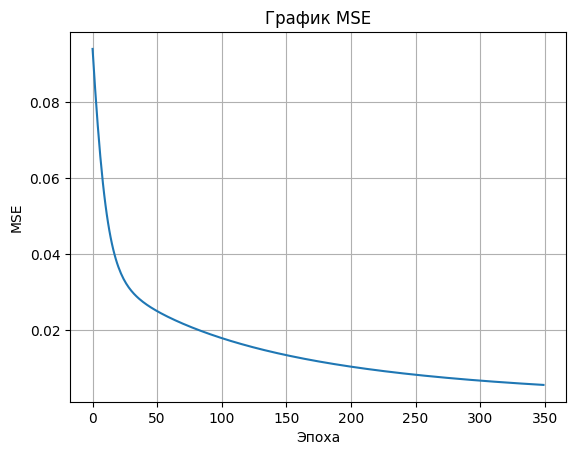

In [9]:
plt.plot(model.history_mse)
plt.xlabel("Эпоха")
plt.ylabel("MSE")
plt.title("График MSE")
plt.grid(True)
plt.show()

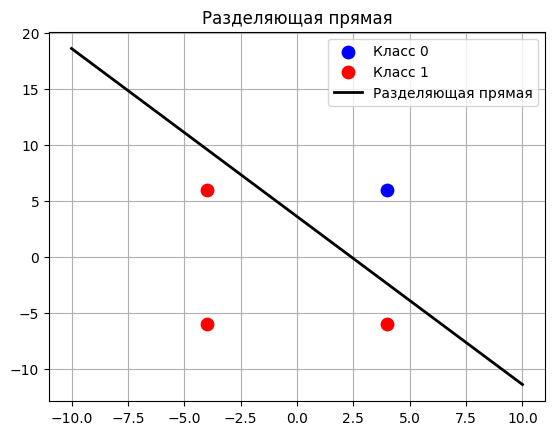

In [10]:
y = np.array(y)

w = model.layers[1].w
b = model.layers[1].b

x_line = np.linspace(-10, 10, 200)
y_line = -(w[0]/w[1]) * x_line - b[0]/w[1]

plt.scatter(
    x[y == 0, 0],
    x[y == 0, 1],
    color='blue',
    s=80,
    label='Класс 0'
)

plt.scatter(
    x[y == 1, 0],
    x[y == 1, 1],
    color='red',
    s=80,
    label='Класс 1'
)

plt.plot(
    x_line, y_line,
    'k-', linewidth=2,
    label='Разделяющая прямая'
)

plt.grid(True)
plt.title("Разделяющая прямая")
plt.legend()
plt.show()

Введите x1 и x2: -2.5 7.6
Класс: 0, прогноз модели: 0.4670


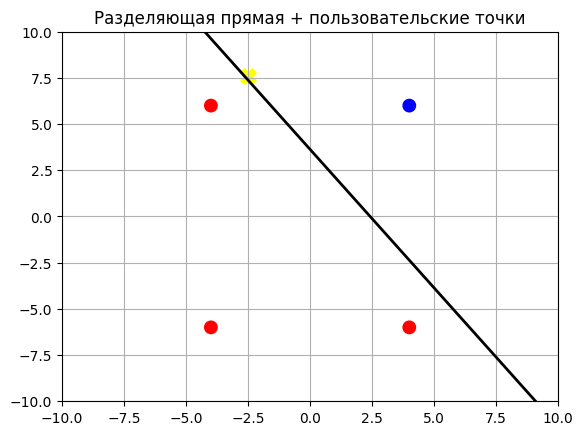

Желаете продолжить? (y/n) y
Введите x1 и x2: -9 5.5
Класс: 1, прогноз модели: 0.9990


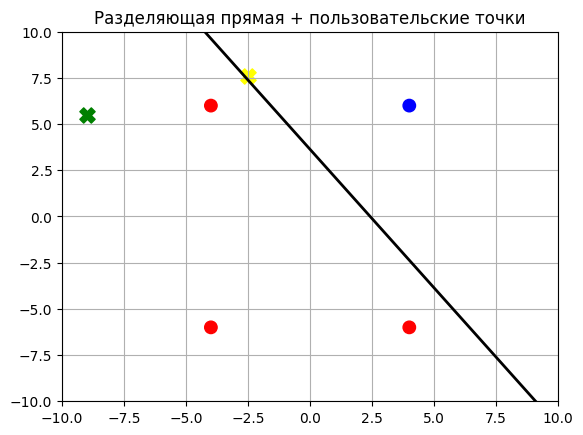

Желаете продолжить? (y/n) y
Введите x1 и x2: 8.1 -5.45
Класс: 0, прогноз модели: 0.1406


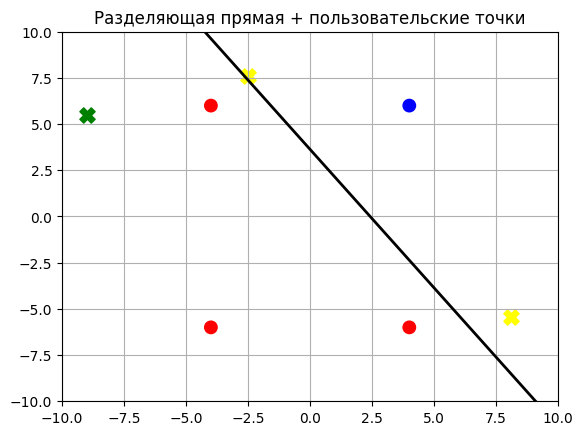

Желаете продолжить? (y/n) n


In [12]:
import matplotlib.pyplot as plt

user_points = []
user_classes = []

while True:
    s = list(map(float, input("Введите x1 и x2: ").split()))

    point = np.array(s, dtype=np.float32)
    x1, x2 = point[0], point[1]

    prediction = model.predict(point.reshape(1, -1))[0][0][0]
    cls = int(prediction > 0.5)

    print(f"Класс: {cls}, прогноз модели: {prediction:.4f}")

    user_points.append([x1, x2])
    user_classes.append(cls)

    plt.clf()

    plt.scatter(x[:,0], x[:,1], c=y, cmap='bwr', s=80)

    for (px, py), c in zip(user_points, user_classes):
        color = "green" if c == 1 else "yellow"
        plt.scatter([px], [py], c=color, s=120, marker='X')

    plt.plot(x_line, y_line, 'k-', linewidth=2)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.grid(True)
    plt.title("Разделяющая прямая + пользовательские точки")

    plt.pause(0.01)

    if input("Желаете продолжить? (y/n) ") == "n":
        break